In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../lib")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import temporal_encoder_common
from temporal_encoder_common import Filters
import nonneg_common
import lif_utils
import nengo
import dlop_ldn_function_bases as bases

In [17]:
n_neurons = 100
n_temporal_dimensions = 100#100

gains, biases, Es = nonneg_common.mk_ensemble(n_neurons, d=n_temporal_dimensions)
G = lif_utils.lif_rate

#A, B = bases.mk_ldn_lti(n_temporal_dimensions)

#T, dt = 10.0, 1e-3
#ts = np.arange(0, T, dt)
#Ms = temporal_encoder_common.cached_lti_impulse_response(A, B, ts)

#N = 10000
#Ms = np.zeros((N, n_temporal_dimensions))
#Ms[:1000] = 5.0 * bases.mk_fourier_basis(n_temporal_dimensions, 1000).T * np.sqrt(1000) * np.linspace(1, 0, 1000)[:, None]

T, dt = 10.0, 1e-3
ts = np.arange(0, T, dt)
N = len(ts)
Ms = np.zeros((N, n_temporal_dimensions))
phis = np.linspace(0, 2 * np.pi * 4.0, n_temporal_dimensions)
for i in range(n_temporal_dimensions):
    decay = int(np.random.uniform(500, 1500))
    Ms[:decay, i] = np.cos(phis[i] * ts[:decay]) * np.linspace(1, 0, decay)
TEs = Es #np.eye(n_neurons)

flts_in = [(100e-3,),]
flts_rec = [(100e-3,),]

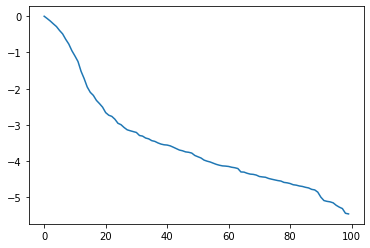

In [18]:
_, S, _ = np.linalg.svd(Ms[:2000])
fig, ax = plt.subplots()
ax.plot(np.log10(S / np.max(S)))

(0.0, 2.0)

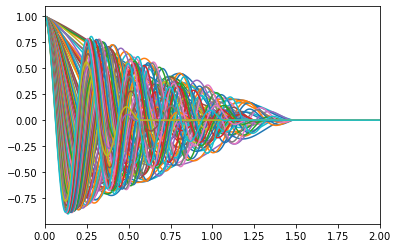

In [19]:
fig, ax = plt.subplots()
ax.plot(ts, Ms);
ax.set_xlim(0, 2)

In [20]:
S[20]  / S[0]

0.002198616908557017

In [21]:
S / np.max(S)

array([1.00000000e+00, 8.61503073e-01, 7.36334277e-01, 6.15630990e-01,
       5.19287266e-01, 4.05044585e-01, 3.26400457e-01, 2.31562213e-01,
       1.71547702e-01, 1.12652566e-01, 8.04567375e-02, 5.64018534e-02,
       3.02710868e-02, 1.90789266e-02, 1.12034597e-02, 7.95845825e-03,
       6.55099061e-03, 4.76934912e-03, 3.88713069e-03, 3.10489877e-03,
       2.19861691e-03, 1.86400752e-03, 1.72886953e-03, 1.44539707e-03,
       1.11508729e-03, 1.01881067e-03, 8.52183386e-04, 7.36902194e-04,
       6.93320095e-04, 6.56481238e-04, 6.22026244e-04, 5.13724427e-04,
       4.94071347e-04, 4.36931987e-04, 4.14494557e-04, 3.69861581e-04,
       3.53016510e-04, 3.20459994e-04, 2.97600209e-04, 2.84489450e-04,
       2.79672486e-04, 2.65928919e-04, 2.44005940e-04, 2.22587781e-04,
       2.03412991e-04, 1.94505612e-04, 1.81173158e-04, 1.76767751e-04,
       1.68040944e-04, 1.44427817e-04, 1.33089753e-04, 1.23146028e-04,
       1.07592769e-04, 1.00461072e-04, 9.54041259e-05, 8.83472289e-05,
      

(0.0, 2.0)

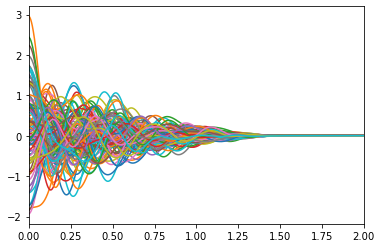

In [13]:
fig, ax = plt.subplots()
ax.plot(ts, Ms @ TEs);
ax.set_xlim(0, 2)

In [15]:
W_in, W_rec = temporal_encoder_common.solve_for_recurrent_population_weights(
    G, gains, biases, None, None, Es,
    [Filters.lowpass(*flt_in) for flt_in in flts_in],
    [Filters.lowpass(*flt_rec) for flt_rec in flts_rec],
    Ms=Ms,
    N_smpls=100,
    biased=True,
    bias_cstr_count=3)

100%|██████████| 100/100 [00:12<00:00,  7.71it/s]


In [218]:
#xs = np.linspace(-1, 1, 100)
#A_post = G(gains[None, :] * (xs[:, None] @ Es.T) + biases[None, :])
#print(A_post.shape)
#
#fig, ax = plt.subplots()
#ax.plot(xs, A_post @ W_rec[:, :, 0]);

In [220]:
#xs = np.linspace(-1, 1, 100)
#A_post = G(gains[None, :] * (xs[:, None] @ Es.T) + biases[None, :])
#print(A_post.shape)

#fig, ax = plt.subplots()
#ax.plot(xs, A_post @ U[:, 0] * S[0]);

(0.0, 100.0)

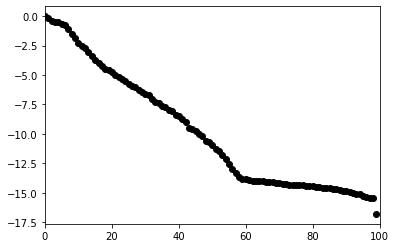

In [16]:
U, S, V = np.linalg.svd(W_rec[:, :, 0])
fig, ax = plt.subplots()
ax.plot(np.log10(S / np.max(S)), 'ko')
ax.set_xlim(0, 100)

In [222]:
from nengo.utils.ensemble import response_curves, tuning_curves

def LP(*args):
    return nengo.LinearFilter(*Filters.lowpass_laplace(*args), analog=True)

with nengo.Network() as model:
    #nd_in = nengo.Node(lambda t: 1.0 * (t > 0.5 and t < 1.5))
    nd_in = nengo.Node(nengo.processes.WhiteSignal(period=10.0, high=2.0, y0=0.0, rms=0.5))
    ens_x = nengo.Ensemble(
        n_neurons=n_neurons,
        dimensions=n_temporal_dimensions,
        bias=biases,
        gain=gains,
        encoders=Es,)
    ens_ref = nengo.Ensemble(
        n_neurons=n_neurons,
        dimensions=n_temporal_dimensions,
        bias=biases,
        gain=gains,
        encoders=Es,)

#    nengo.Connection(nd_in, ens_ref, transform=0.1 * B.reshape(-1, 1), synapse=LP(0.1))
#    C_ref = nengo.Connection(ens_ref, ens_ref, transform=0.1 * A + np.eye(n_temporal_dimensions), synapse=LP(0.1))

    for i, flt_in in enumerate(flts_in):
        nengo.Connection(
            nd_in, ens_x.neurons,
            transform=W_in[:, i].reshape(-1, 1),
            synapse=LP(*flt_in))

    for i, flt_rec in enumerate(flts_rec):
        nengo.Connection(
            ens_x.neurons, ens_x.neurons,
            transform=W_rec[:, :, i],
            synapse=LP(*flt_rec))

    p_in = nengo.Probe(nd_in, synapse=None)
    p_out = nengo.Probe(ens_x, synapse=100e-3)
    p_out_neurons = nengo.Probe(ens_x.neurons, synapse=None)
    p_ref = nengo.Probe(ens_ref, synapse=100e-3)

with nengo.Simulator(model) as sim:
    sim.run(10.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

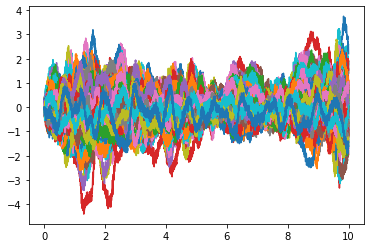

In [223]:
fig, ax = plt.subplots()
ax.plot(sim.trange(), sim.data[p_in])
ax.plot(sim.trange(), 10 * sim.data[p_out]);
#ax.plot(sim.trange(), sim.data[p_ref], 'r-')
#ax.plot(sim.trange(), nengo.Lowpass(100e-3).filt(np.cumsum(sim.data[p_in])) * 1e-3, 'k--')

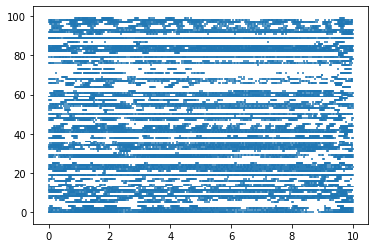

In [224]:
fig, ax = plt.subplots()
ax.eventplot([sim.trange()[sim.data[p_out_neurons][:, i] != 0] for i in range(n_neurons)]);

In [90]:
np.sqrt(np.sum(np.square(W_rec))), np.sqrt(np.sum(np.square(Es @ sim.data[C_ref].weights)))

NameError: name 'C_ref' is not defined

In [98]:
#_, S, _ = np.linalg.svd(Es @ sim.data[C_ref].weights)
#fig, ax = plt.subplots()
#ax.plot(np.log10(S / np.max(S)))

In [99]:
T, dt = 10.0, 1e-3
ts = np.arange(0, T, dt)
Ms = temporal_encoder_common.cached_lti_impulse_response(A, B, ts, dt)

In [100]:
xs = np.linspace(-1, 1, 100)
A_post = G(gains[None, :] * (xs[:, None] @ Es.T) + biases[None, :])
print(A_post.shape)

fig, ax = plt.subplots()
ax.plot(xs, A_post @ sim.data[C_ref].weights.T);
ax.plot(xs, A_post @ U[:, 0] * S[0] * 0.1);

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 5 is different from 1)

In [30]:

def eval_lti(A, B, ts):
    import scipy.linalg
    return np.array([scipy.linalg.expm(A * t) @ B for t in ts])

def eval_lti_euler(A, B, N, dt):
    import scipy.linalg
    Ad = scipy.linalg.expm(A * dt)
    Bd = np.linalg.solve(A, (Ad - np.eye(A.shape[0])) @ B)
    res = np.zeros((N, A.shape[0]))
    res[0, :] = B
    for i in range(1, N):
        res[i, :] = Ad @ res[i - 1, :]
    return res


In [31]:
A, B = bases.mk_ldn_lti(6)
T, dt = 10.0, 1e-3

In [32]:
ts = np.arange(0, T, dt)
res1 = eval_lti(A, B, ts)

In [33]:
res2 = eval_lti_euler(A, B, len(ts), dt)

(0.0, 0.01)

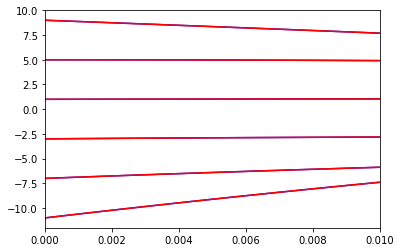

In [34]:
fig, ax = plt.subplots()
ax.plot(ts, res1, 'b')
ax.plot(ts, res2, 'r')
ax.set_xlim(0, 0.01)